In [1]:
import torch
from sam2.build_sam import build_sam2 # for images
from sam2.build_sam import build_sam2_video_predictor # for videos

from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.sam2_image_predictor import SAM2ImagePredictor

import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='cuda')

# Image Segmentation

In [3]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

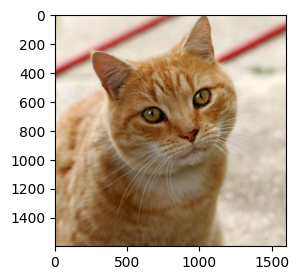

In [4]:
image = cv2.imread("/home/niru/Downloads/Cat03.jpg")
# cv2.imshow("frame", image)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.show()


In [5]:
checkpoint = "segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = SAM2AutomaticMaskGenerator(build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False))

masks = predictor.generate(image)


/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory efficient kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:723.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Memory Efficient attention has been runtime disabled. (Triggered internally at ../aten/src/ATen/native/transformers/sdp_utils_cpp.h:495.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:270: UserWarning: Flash attention kernel not used because: (Triggered internally at ../aten/src/ATen/native/transformers/cuda/sdp_utils.cpp:725.)
  out = F.scaled_dot_product_attention(q, k, v, dropout_p=dropout_p)
/home/niru/codes/disassembly/SAM2/segment-anything-2/sam2/modeling/sam/transformer.py:

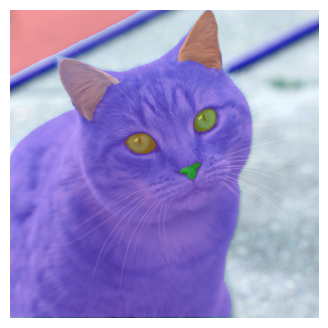

In [6]:
import supervision as sv

mask_annotator = sv.MaskAnnotator()
detections = sv.Detections.from_sam(masks)
detections.class_id = [i for i in range(len(detections))]
annotated_image = mask_annotator.annotate(image, detections)

sv.plot_image(image=annotated_image, size=(4, 4))

# Video Segmentation

In [7]:
checkpoint = "segment-anything-2/checkpoints/sam2_hiera_small.pt"
config = "sam2_hiera_s.yaml"
model = build_sam2_video_predictor(config, checkpoint, device=device)

In [8]:
import supervision as sv

frames_generator = sv.get_video_frames_generator("/home/niru/Downloads/IMG_0066-ezgif.com-video-to-mp4-converter.mp4")
sink = sv.ImageSink(
    target_dir_path="video-frames",
    image_name_pattern="{:05d}.jpeg")

with sink:
    for frame in frames_generator:
        sink.save_image(frame)

In [9]:
inference_state = model.init_state("video-frames")
model.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 427/427 [00:18<00:00, 23.50it/s]


In [10]:
# Selecting points in first frame (will be automated later)

def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img, (x, y), 3, (0, 0, 255), -1)
        points.append(np.array([x, y]))
        cv2.imshow('image', img)

points = []
img = cv2.imread('/home/niru/codes/disassembly/SAM2/video-frames/00000.jpeg') # Replace 'your_image.jpg' with your image path
cv2.imshow('image', img)
cv2.setMouseCallback('image', click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()
points = np.array(points)
print("Selected Points:", points)


Selected Points: [[ 730  559]
 [1280  747]]


In [11]:
prompts = {}

labels = np.array([1])
frame_idx = 0
tracker_id_1 = 1

prompts[tracker_id_1] = points[0], labels

_, object_ids, mask_logits = model.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=tracker_id_1,
    points=[points[0]],
    labels=labels,
)

tracker_id_2 = 2
prompts[tracker_id_2] = points[1], labels

_, object_ids, mask_logits = model.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=tracker_id_2,
    points=[points[1]],
    labels=labels,
)



Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).


In [12]:
colors = ['#FF1493', '#00BFFF', '#FF6347', '#FFD700']
mask_annotator = sv.MaskAnnotator(
    color=sv.ColorPalette.from_hex(colors),
    color_lookup=sv.ColorLookup.TRACK)

video_info = sv.VideoInfo.from_video_path("/home/niru/Downloads/IMG_0066-ezgif.com-video-to-mp4-converter.mp4")
frames_paths = sorted(sv.list_files_with_extensions(
    directory="/home/niru/codes/disassembly/SAM2/video-frames", 
    extensions=["jpeg"]))


with sv.VideoSink("final_output.mp4", video_info=video_info) as sink:
    for frame_idx, object_ids, mask_logits in model.propagate_in_video(inference_state):
        frame = cv2.imread(frames_paths[frame_idx])
        masks = (mask_logits > 0.0).cpu().numpy()
        N, X, H, W = masks.shape
        masks = masks.reshape(N * X, H, W)
        detections = sv.Detections(
            xyxy=sv.mask_to_xyxy(masks=masks),
            mask=masks,
            tracker_id=np.array(object_ids)
        )
        frame = mask_annotator.annotate(frame, detections)
        sink.write_frame(frame)

propagate in video: 100%|██████████| 427/427 [03:51<00:00,  1.85it/s]
